## 8.0 Reload Data and Build Safe Top-27 Training Table (CVAE Version)

In this notebook we train a Conditional VAE (CVAE) on the same Safe Top-27
feature set used in the CTGAN notebook.

In this section we:

1. Reload the merged training data from `outputs_merged/train_merged.parquet`.
2. Reconstruct the cleaned table `df_clean` that contains:
   - the Safe Top-27 numerical features (`safe_top_feats`)
   - the binary label `label`
3. Create an 80/20 stratified split:
   - `X_train_syn`, `y_train_syn`: training split used to fit the CVAE
   - `X_val_real`, `y_val_real`: held-out real validation set

Later sections will:
- Normalize the Safe Top-27 features,
- Train a CVAE conditioned on the label,
- Generate 200k synthetic samples for utility and fidelity evaluation.

In [17]:
# === 8.0 Reload data and build Safe Top-27 training table (CVAE version) ===
import pandas as pd
from sklearn.model_selection import train_test_split

# 1) Load merged training data (same source as CTGAN notebook)
train_path = "outputs_merged/train_merged.parquet"
df = pd.read_parquet(train_path)

print("Loaded merged train:", df.shape)
print("CTR (positive rate):", df["label"].mean())

# 2) Safe Top-27 feature list (same as before)
safe_top_feats = [
    "creat_type_cd", "f_cat_uniq", "f_refresh_sum", "slot_id", "f_rows",
    "f_up_sum", "f_dislike_sum", "f_refresh_mean", "u_refreshTimes",
    "u_newsCatInterestsST_len", "f_up_mean", "u_feedLifeCycle",
    "u_newsCatInterestsST_uniq", "f_entities_len_mean", "f_dislike_mean",
    "f_browser_life", "adv_prim_id", "device_size", "adv_id", "task_id",
    "inter_type_cd", "hispace_app_tags", "spread_app_id", "app_second_class",
    "ad_click_list_v002_uniq", "ad_click_list_v002_len", "f_hour_cos"
]

# 3) Build cleaned table: Safe Top-27 + label
df_clean = df[safe_top_feats + ["label"]].copy()

print("Clean dataset:", df_clean.shape)
print("Columns (first 10):", df_clean.columns.tolist()[:10], "...")

# 4) Stratified train / validation split (for CVAE + later evaluation)
X = df_clean.drop(columns=["label"])
y = df_clean["label"].astype(int)

X_train_syn, X_val_real, y_train_syn, y_val_real = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Synthetic training area :", X_train_syn.shape)
print("Real validation set     :", X_val_real.shape)
print("CTR (train):", y_train_syn.mean(), "CTR (valid):", y_val_real.mean())

Loaded merged train: (7675517, 68)
CTR (positive rate): 0.01552156030662169
Clean dataset: (7675517, 28)
Columns (first 10): ['creat_type_cd', 'f_cat_uniq', 'f_refresh_sum', 'slot_id', 'f_rows', 'f_up_sum', 'f_dislike_sum', 'f_refresh_mean', 'u_refreshTimes', 'u_newsCatInterestsST_len'] ...
Synthetic training area : (6140413, 27)
Real validation set     : (1535104, 27)
CTR (train): 0.01552159439438357 CTR (valid): 0.01552142395564079


## 8.1 Build Normalized Inputs for CVAE

Before training the Conditional Variational Autoencoder (CVAE), we normalize the
Safe Top-27 features so that all inputs fall into a stable range. This greatly
improves reconstruction quality and prevents the model from being dominated by
features with large numeric scales.

**In this section:**

1. Fit `MinMaxScaler` on the training split (`X_train_syn[safe_top_feats]`).
2. Transform both:
   - `X_train_syn` → `X_cvae_train`
   - `X_val_real` → `X_cvae_val_real`
3. Keep the label `y_train_syn` and `y_val_real` unchanged (the label is not scaled).
4. Save the scaler as `cvae_safe27_scaler.pkl` for later use when decoding synthetic samples.

The output tensors will be used in Section 8.2 when we construct the CVAE model.

In [20]:
# === 8.1 Build normalized inputs for CVAE ===
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pickle

# 1) Safety check
needed_vars = ["df_clean", "safe_top_feats", "X_train_syn", "X_val_real"]
for v in needed_vars:
    if v not in globals():
        raise RuntimeError(f"{v} not found. Please run Section 8.0 first.")

# 2) Fit MinMaxScaler on real training split (Safe Top-27 features only)
scaler_cvae = MinMaxScaler()
scaler_cvae.fit(X_train_syn[safe_top_feats])

# 3) Transform train + validation sets
X_cvae_train = scaler_cvae.transform(X_train_syn[safe_top_feats])
X_cvae_val_real = scaler_cvae.transform(X_val_real[safe_top_feats])

print("X_cvae_train shape    :", X_cvae_train.shape)
print("X_cvae_val_real shape :", X_cvae_val_real.shape)

# Quick check: scaled range
print("Train feature min (col-wise):", X_cvae_train.min(axis=0)[:5], "...")
print("Train feature max (col-wise):", X_cvae_train.max(axis=0)[:5], "...")

# 4) Save scaler for decoding synthetic data later
with open("cvae_safe27_scaler.pkl", "wb") as f:
    pickle.dump(scaler_cvae, f)

print("Saved scaler -> cvae_safe27_scaler.pkl")

X_cvae_train shape    : (6140413, 27)
X_cvae_val_real shape : (1535104, 27)
Train feature min (col-wise): [0. 0. 0. 0. 0.] ...
Train feature max (col-wise): [1. 1. 1. 1. 1.] ...
Saved scaler -> cvae_safe27_scaler.pkl


## 8.2 Build CVAE training tensors and define model

In this section, we construct the inputs for a **Conditional Variational Autoencoder (CVAE)** and define the model architecture.

Unlike a plain VAE, the CVAE is explicitly **conditioned on the binary label**:

- During training, each sample is represented by:
  - Scaled feature vector `x ∈ ℝ^27` (Safe Top-27, MinMax-scaled)
  - Binary label `y ∈ {0, 1}`

- The encoder takes the concatenation `[x, y]` as input and outputs:
  - Mean vector `μ(x, y) ∈ ℝ^16`
  - Log-variance vector `log σ²(x, y) ∈ ℝ^16`

- The decoder receives the concatenation `[z, y]`, where `z` is a latent code
  sampled from `N(μ, σ²)`, and reconstructs the scaled feature vector `x̂`.

This design encourages the latent space to capture **label-dependent structure**
and avoids collapsing all samples into a single “average CTR user”.

**Steps in this section:**

1. Convert `X_cvae_train` and `X_cvae_val_real` into `float32` NumPy arrays.
2. Move them into PyTorch tensors on CPU.
3. Define a CVAE model with:
   - Input dimension: 27 feature dims + 1 label dim
   - Latent dimension: 16
   - Hidden layers: two 64-unit ReLU layers in both encoder and decoder
4. Print the model summary to verify shapes and modules.

The resulting `cvae` model will be trained in Section 8.3.

In [24]:
# === 8.2 Build CVAE training tensors and define model ===
import numpy as np
import torch
from torch import nn

# 1) Safety check
needed_vars = ["X_cvae_train", "X_cvae_val_real", "y_train_syn", "y_val_real"]
for v in needed_vars:
    if v not in globals():
        raise RuntimeError(f"{v} not found. Please run Sections 8.0–8.1 first.")

# 2) Convert scaled features to float32 NumPy arrays
X_cvae_train_full = X_cvae_train.astype("float32")
X_cvae_val_full   = X_cvae_val_real.astype("float32")

print("X_cvae_train_full shape:", X_cvae_train_full.shape)
print("X_cvae_val_full shape  :", X_cvae_val_full.shape)

# 3) Label arrays (as float32, since they go into the network)
y_train_arr = y_train_syn.astype("float32").values.reshape(-1, 1)
y_val_arr   = y_val_real.astype("float32").values.reshape(-1, 1)

print("y_train_arr shape:", y_train_arr.shape)
print("y_val_arr shape  :", y_val_arr.shape)

# 4) Basic dimensions
x_dim      = X_cvae_train_full.shape[1]  # 27
cond_dim   = 1                           # label y
input_dim  = x_dim + cond_dim           # encoder input: [x, y]
latent_dim = 16
hidden_dim = 64

print("x_dim     :", x_dim)
print("input_dim :", input_dim)
print("latent_dim:", latent_dim)

# 5) Convert to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

x_train_tensor = torch.from_numpy(X_cvae_train_full).to(device)
x_val_tensor   = torch.from_numpy(X_cvae_val_full).to(device)

y_train_tensor = torch.from_numpy(y_train_arr).to(device)
y_val_tensor   = torch.from_numpy(y_val_arr).to(device)


# 6) Define Conditional VAE
class CVAE(nn.Module):
    def __init__(self, x_dim, cond_dim, hidden_dim, latent_dim):
        super(CVAE, self).__init__()

        enc_input_dim = x_dim + cond_dim    # [x, y]
        dec_input_dim = latent_dim + cond_dim  # [z, y]

        # ----- Encoder -----
        self.encoder = nn.Sequential(
            nn.Linear(enc_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu     = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # ----- Decoder -----
        self.decoder = nn.Sequential(
            nn.Linear(dec_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, x_dim),
            nn.Sigmoid(),  # outputs in [0, 1] to match MinMax-scaled features
        )

    def encode(self, x, y):
        # x: (batch, x_dim), y: (batch, 1)
        enc_input = torch.cat([x, y], dim=1)
        h = self.encoder(enc_input)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        # z: (batch, latent_dim), y: (batch, 1)
        dec_input = torch.cat([z, y], dim=1)
        x_recon = self.decoder(dec_input)
        return x_recon

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, y)
        return x_recon, mu, logvar


# 7) Instantiate CVAE model
cvae = CVAE(
    x_dim=x_dim,
    cond_dim=cond_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
).to(device)

print(cvae)

X_cvae_train_full shape: (6140413, 27)
X_cvae_val_full shape  : (1535104, 27)
y_train_arr shape: (6140413, 1)
y_val_arr shape  : (1535104, 1)
x_dim     : 27
input_dim : 28
latent_dim: 16
Using device: cpu
CVAE(
  (encoder): Sequential(
    (0): Linear(in_features=28, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=64, out_features=16, bias=True)
  (fc_logvar): Linear(in_features=64, out_features=16, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=17, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=27, bias=True)
    (5): Sigmoid()
  )
)


## 8.3 Train CVAE on a sub-sampled training set

The full training split has about 6.1M rows, which is too large to train in a single pass on CPU. To make training feasible, we:

1. Randomly sample:
   - **500,000** rows from the training split for CVAE training.
   - **100,000** rows from the validation split for monitoring the loss.

2. Build PyTorch `DataLoader`s over `(x, y)` pairs, where:
   - `x` is the 27-dimensional **MinMax-scaled** feature vector.
   - `y` is the binary label used as a **condition**.

3. Train the CVAE with mini-batch stochastic gradient descent:
   - **Reconstruction loss**: mean squared error (MSE) between input features `x`
     and reconstructed features `x̂`.
   - **KL divergence**: regularizer pushing the latent distribution towards a
     standard normal prior `N(0, I)`.

4. Use the total loss:
   \[
   \mathcal{L} = \text{MSE}(x, \hat{x}) + \beta \cdot \text{KL}(q(z \mid x, y) \parallel N(0, I)),
   \]
   with \(\beta = 1.0\).

We log the training and validation losses (total, reconstruction, and KL) at the end of each epoch.
The trained `cvae` model will then be used in Section 8.4 to generate label-conditioned synthetic samples.

In [27]:
# === 8.3 Train CVAE on a sub-sampled training set ===
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

# 1) Safety check
needed_vars = ["x_train_tensor", "x_val_tensor",
               "y_train_tensor", "y_val_tensor",
               "cvae", "device"]
for v in needed_vars:
    if v not in globals():
        raise RuntimeError(f"{v} not found. Please run Sections 8.1–8.2 first.")

# 2) Sub-sample training and validation for feasible CPU training
N_CVAE_TRAIN = 500_000
N_CVAE_VAL   = 100_000

n_train_total = x_train_tensor.shape[0]
n_val_total   = x_val_tensor.shape[0]

np.random.seed(42)

train_idx = np.random.choice(
    n_train_total,
    size=min(N_CVAE_TRAIN, n_train_total),
    replace=False
)
val_idx = np.random.choice(
    n_val_total,
    size=min(N_CVAE_VAL, n_val_total),
    replace=False
)

x_train_sub = x_train_tensor[train_idx]
y_train_sub = y_train_tensor[train_idx]

x_val_sub = x_val_tensor[val_idx]
y_val_sub = y_val_tensor[val_idx]

print("[8.3] x_train_sub shape:", x_train_sub.shape)
print("[8.3] y_train_sub shape:", y_train_sub.shape)
print("[8.3] x_val_sub shape  :", x_val_sub.shape)
print("[8.3] y_val_sub shape  :", y_val_sub.shape)

# 3) Build DataLoaders over (x, y)
batch_size = 1024

train_loader = DataLoader(
    TensorDataset(x_train_sub, y_train_sub),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

val_loader = DataLoader(
    TensorDataset(x_val_sub, y_val_sub),
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
)

# 4) CVAE loss: reconstruction + KL divergence
def cvae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction loss over all dimensions (MSE)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction="mean")
    # KL divergence between q(z|x,y) and N(0, I)
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kld, recon_loss, kld

# 5) Optimizer
learning_rate = 1e-3
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# 6) Training loop
num_epochs = 10

cvae.train()
for epoch in range(1, num_epochs + 1):
    # ----- training -----
    train_loss_sum = 0.0
    train_recon_sum = 0.0
    train_kld_sum = 0.0
    n_train_batches = 0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        recon_x, mu, logvar = cvae(batch_x, batch_y)
        loss, recon_loss, kld = cvae_loss_function(recon_x, batch_x, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss_sum  += loss.item()
        train_recon_sum += recon_loss.item()
        train_kld_sum   += kld.item()
        n_train_batches += 1

    avg_train_loss  = train_loss_sum  / n_train_batches
    avg_train_recon = train_recon_sum / n_train_batches
    avg_train_kld   = train_kld_sum   / n_train_batches

    # ----- validation -----
    cvae.eval()
    with torch.no_grad():
        val_loss_sum = 0.0
        val_recon_sum = 0.0
        val_kld_sum = 0.0
        n_val_batches = 0

        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            recon_x, mu, logvar = cvae(batch_x, batch_y)
            loss, recon_loss, kld = cvae_loss_function(recon_x, batch_x, mu, logvar)

            val_loss_sum  += loss.item()
            val_recon_sum += recon_loss.item()
            val_kld_sum   += kld.item()
            n_val_batches += 1

    avg_val_loss  = val_loss_sum  / n_val_batches
    avg_val_recon = val_recon_sum / n_val_batches
    avg_val_kld   = val_kld_sum   / n_val_batches

    cvae.train()

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={avg_train_loss:.4f} "
        f"(recon={avg_train_recon:.4f}, kld={avg_train_kld:.4f}) | "
        f"val_loss={avg_val_loss:.4f} "
        f"(recon={avg_val_recon:.4f}, kld={avg_val_kld:.4f})"
    )

print("[8.3] CVAE training finished.")

[8.3] x_train_sub shape: torch.Size([500000, 27])
[8.3] y_train_sub shape: torch.Size([500000, 1])
[8.3] x_val_sub shape  : torch.Size([100000, 27])
[8.3] y_val_sub shape  : torch.Size([100000, 1])
Epoch 01 | train_loss=0.0589 (recon=0.0588, kld=0.0002) | val_loss=0.0551 (recon=0.0551, kld=0.0000)
Epoch 02 | train_loss=0.0548 (recon=0.0548, kld=0.0000) | val_loss=0.0548 (recon=0.0548, kld=0.0000)
Epoch 03 | train_loss=0.0546 (recon=0.0546, kld=0.0000) | val_loss=0.0547 (recon=0.0547, kld=0.0000)
Epoch 04 | train_loss=0.0546 (recon=0.0546, kld=0.0000) | val_loss=0.0547 (recon=0.0547, kld=0.0000)
Epoch 05 | train_loss=0.0546 (recon=0.0546, kld=0.0000) | val_loss=0.0547 (recon=0.0547, kld=0.0000)
Epoch 06 | train_loss=0.0546 (recon=0.0546, kld=0.0000) | val_loss=0.0547 (recon=0.0547, kld=0.0000)
Epoch 07 | train_loss=0.0546 (recon=0.0546, kld=0.0000) | val_loss=0.0547 (recon=0.0547, kld=0.0000)
Epoch 08 | train_loss=0.0546 (recon=0.0545, kld=0.0000) | val_loss=0.0547 (recon=0.0547, kld=0.

## 8.4 Generate 200k label-conditioned synthetic samples with CVAE

In this section we use the trained CVAE to generate 200,000 synthetic feature
vectors **conditioned on the label**. This follows the “conditional VAE”
strategy:

1. The CVAE was trained on concatenated inputs:
   - 27-dimensional MinMax-scaled feature vector `x`.
   - 1-dimensional binary label `y ∈ {0, 1}`.

2. At generation time we:
   - Sample synthetic labels `y_syn` from a Bernoulli distribution with success
     probability equal to the **real CTR** on the training split.
   - Sample latent codes `z ~ N(0, I)` with dimension 16.
   - Decode `(z, y_syn)` through the CVAE decoder to obtain `x̂` in the
     scaled feature space `[0, 1]^{27}`.

3. We then apply the fitted MinMax scaler to **invert the scaling** back to
   the original feature space, and build a synthetic table:
   - 200,000 rows.
   - Same schema as the real data: `safe_top_feats + ["label"]`.

4. The resulting table is saved as:
   - `synthetic/cvae_safe_top27_200k.parquet`
   - `synthetic/cvae_safe_top27_200k.csv`

This synthetic dataset will be used in later sections for utility and fidelity
evaluation, in direct comparison with CTGAN and real-data baselines.

In [35]:
# === 8.4 Generate 200k label-conditioned synthetic samples with CVAE ===
import os
import numpy as np
import pandas as pd
import torch

# 1) Safety check
needed_vars = ["cvae", "device", "scaler_cvae",
               "safe_top_feats", "y_train_syn"]
for v in needed_vars:
    if v not in globals():
        raise RuntimeError(f"{v} not found. Please make sure Sections 8.0–8.3 ran correctly.")

# 2) Number of synthetic samples to generate
N_SYNTH_CVAE = 200_000
latent_dim   = 16           # must match the definition in Section 8.2
x_dim        = len(safe_top_feats)

print(f"[8.4] Generating {N_SYNTH_CVAE:,} synthetic rows with CVAE...")

# 3) Estimate real CTR from the training split
real_ctr = float(y_train_syn.mean())
print(f"[8.4] Real CTR (train split) ≈ {real_ctr:.5f}")

# 4) Sample synthetic labels from Bernoulli(real_ctr)
y_syn_np = np.random.binomial(1, real_ctr, size=N_SYNTH_CVAE).astype("float32")
y_syn_tensor = torch.from_numpy(y_syn_np.reshape(-1, 1)).to(device)

# 5) Sample latent codes z ~ N(0, I)
cvae.eval()
with torch.no_grad():
    z = torch.randn(N_SYNTH_CVAE, latent_dim, device=device)

    # 6) Decode to scaled feature space given (z, y_syn)
    x_scaled = cvae.decode(z, y_syn_tensor)  # shape: (N_SYNTH_CVAE, 27)
    x_scaled = x_scaled.clamp(0.0, 1.0)      # ensure within [0, 1]
    x_scaled_np = x_scaled.cpu().numpy()

print("[8.4] Scaled feature matrix shape:", x_scaled_np.shape)

# 7) Inverse-transform to original feature space
X_cvae_syn = scaler_cvae.inverse_transform(x_scaled_np)
print("[8.4] Inverse-transformed feature matrix shape:", X_cvae_syn.shape)

# 8) Build DataFrame with Safe Top-27 feature names
df_cvae_syn = pd.DataFrame(X_cvae_syn, columns=safe_top_feats)

# 9) Attach the synthetic labels (already sampled above)
df_cvae_syn["label"] = y_syn_np.astype(int)

print("[8.4] df_cvae_syn shape:", df_cvae_syn.shape)
print("[8.4] Synthetic CTR (label=1):", df_cvae_syn["label"].mean())

# 10) Ensure output folder exists
os.makedirs("synthetic", exist_ok=True)

parquet_path = "synthetic/cvae_safe_top27_200k.parquet"
csv_path     = "synthetic/cvae_safe_top27_200k.csv"

df_cvae_syn.to_parquet(parquet_path, index=False)
df_cvae_syn.to_csv(csv_path, index=False)

print("[8.4] Saved CVAE synthetic table ->", parquet_path)
print("[8.4] Saved CVAE synthetic CSV   ->", csv_path)

# Quick peek
df_cvae_syn.head()

[8.4] Generating 200,000 synthetic rows with CVAE...
[8.4] Real CTR (train split) ≈ 0.01552
[8.4] Scaled feature matrix shape: (200000, 27)
[8.4] Inverse-transformed feature matrix shape: (200000, 27)
[8.4] df_cvae_syn shape: (200000, 28)
[8.4] Synthetic CTR (label=1): 0.015495
[8.4] Saved CVAE synthetic table -> synthetic/cvae_safe_top27_200k.parquet
[8.4] Saved CVAE synthetic CSV   -> synthetic/cvae_safe_top27_200k.csv


,creat_type_cd,f_cat_uniq,f_refresh_sum,slot_id,f_rows,f_up_sum,f_dislike_sum,f_refresh_mean,u_refreshTimes,u_newsCatInterestsST_len,...,adv_id,task_id,inter_type_cd,hispace_app_tags,spread_app_id,app_second_class,ad_click_list_v002_uniq,ad_click_list_v002_len,f_hour_cos,label
0,7.896004,34.208107,625.468201,32.152691,93.817986,326.307495,166.190979,5.759792,5.787621,4.810194,...,16589.427734,23599.671875,4.245053,37.035450,235.173218,17.782257,4.228443,4.234645,-0.615019,0
1,7.882845,34.639603,649.472229,32.248718,93.467461,326.205414,167.891953,5.833440,5.841303,4.799074,...,16526.460938,23634.990234,4.242644,36.769512,236.535706,17.794353,4.242957,4.247216,-0.617747,0
2,7.924710,34.149483,612.331909,32.049782,90.283188,317.386047,164.529739,5.820117,5.828493,4.803434,...,16513.166016,23623.312500,4.249818,37.008034,235.975479,17.762125,4.245383,4.243495,-0.616213,0
3,7.888657,34.195656,620.546204,32.042198,91.570992,325.641602,169.242615,5.805466,5.816727,4.801252,...,16525.896484,23701.400391,4.248176,37.015766,235.786575,17.723602,4.241569,4.255028,-0.617470,0
4,7.885337,34.277103,660.619873,32.179035,95.140717,327.458771,171.022079,5.800739,5.816264,4.800978,...,16579.062500,23596.498047,4.239877,36.808517,236.507782,17.800562,4.241090,4.243266,-0.613810,0


## 8.5 Utility Evaluation: LightGBM on CVAE Synthetic 200k → Real Validation

**Goal**

In this section, we evaluate the downstream utility of the **CVAE-generated**
synthetic data. The setup mirrors the earlier CTGAN experiment:

- Train a LightGBM model on **200,000 CVAE synthetic rows**  
  (`cvae_safe_top27_200k.parquet`, Safe Top-27 features + `label`).
- Evaluate the model on the held-out **real validation set**
  (`X_val_real`, `y_val_real` from Section 8.0).

We will compare the performance with:

- LightGBM trained on **200k real rows** → real validation.
- LightGBM trained on **200k CTGAN synthetic rows** → real validation.

**Inputs**

- `safe_top_feats`: Safe Top-27 feature names (Section 8.0).
- `X_val_real`, `y_val_real`: real validation split (Section 8.0).
- `synthetic/cvae_safe_top27_200k.parquet`:
  200,000 CVAE synthetic samples from Section 8.4.

**Outputs**

- A LightGBM model trained on 200k CVAE synthetic rows.
- Utility metrics on the real validation set:

  - ROC-AUC, PR-AUC, LogLoss, Accuracy, Precision, Recall, F1.

These metrics will be compared against the CTGAN and real-data baselines in the
final report.

In [38]:
# ============================================================
# 8.5 Utility: Train on CVAE synthetic 200k, test on REAL validation
# ============================================================

import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import (
    roc_auc_score, average_precision_score, log_loss,
    accuracy_score, precision_score, recall_score, f1_score
)

# 1) Sanity check for required objects
needed_vars = ["safe_top_feats", "X_val_real", "y_val_real"]
for v in needed_vars:
    if v not in globals():
        raise RuntimeError(f"{v} not found. Please run Sections 8.0–8.1 first.")

# 2) Load CVAE synthetic 200k table
cvae_syn_path = "synthetic/cvae_safe_top27_200k.parquet"
df_cvae_syn_200k = pd.read_parquet(cvae_syn_path)

print("[8.5] Loaded df_cvae_syn_200k:", df_cvae_syn_200k.shape)
print("[8.5] CVAE synthetic CTR:", df_cvae_syn_200k["label"].mean())

# 3) Build training set from CVAE synthetic data (Safe Top-27 only)
X_train_cvae = df_cvae_syn_200k[safe_top_feats].copy()
y_train_cvae = df_cvae_syn_200k["label"].astype(int).copy()

print("[8.5] X_train_cvae shape:", X_train_cvae.shape)
print("[8.5] y_train_cvae mean:", y_train_cvae.mean())

# 4) Real validation set (same as before, Safe Top-27 only)
X_valid_real_cvae = X_val_real[safe_top_feats].copy()
y_valid_real_cvae = y_val_real.astype(int).copy()

print("[8.5] X_valid_real_cvae shape:", X_valid_real_cvae.shape)
print("[8.5] y_valid_real_cvae mean:", y_valid_real_cvae.mean())

# 5) Define LightGBM parameters (similar to previous utility experiments)
base_lgb_params_cvae = {
    "objective": "binary",
    "metric": ["auc", "average_precision"],
    "learning_rate": 0.08,
    "num_leaves": 127,
    "max_depth": -1,
    "min_child_samples": 100,
    "subsample": 0.8,
    "subsample_freq": 1,
    "colsample_bytree": 0.8,
    "lambda_l2": 1.0,
    "n_jobs": -1,
    "seed": 42,
}

# Handle class imbalance using scale_pos_weight from synthetic CTR
pos_rate_cvae = y_train_cvae.mean()
scale_pos_weight_cvae = (1 - pos_rate_cvae) / pos_rate_cvae
base_lgb_params_cvae["scale_pos_weight"] = scale_pos_weight_cvae

print(f"\n[8.5] scale_pos_weight (CVAE synthetic 200k) = {scale_pos_weight_cvae:.2f}")

# 6) Build LightGBM datasets
dtrain_cvae = lgb.Dataset(X_train_cvae, label=y_train_cvae)
dvalid_cvae = lgb.Dataset(X_valid_real_cvae, label=y_valid_real_cvae,
                          reference=dtrain_cvae)

# 7) Train LightGBM on CVAE synthetic data
print("\n[8.5] Training LightGBM on 200k CVAE synthetic rows ...")
model_cvae_syn_200k = lgb.train(
    params=base_lgb_params_cvae,
    train_set=dtrain_cvae,
    num_boost_round=2000,
    valid_sets=[dtrain_cvae, dvalid_cvae],
    valid_names=["train_cvae_syn", "valid_real"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100),
    ],
)

# 8) Predict on the real validation set
y_prob_cvae_syn2real = model_cvae_syn_200k.predict(
    X_valid_real_cvae,
    num_iteration=model_cvae_syn_200k.best_iteration,
)

# 9) Evaluation helper
def eval_cvae_syn2real(y_true, y_proba, threshold=0.5,
                       title="CVAE syn → real"):
    y_pred = (y_proba >= threshold).astype(int)
    metrics = {
        "ROC-AUC": roc_auc_score(y_true, y_proba),
        "PR-AUC": average_precision_score(y_true, y_proba),
        "LogLoss": log_loss(y_true, y_proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
    }
    print(f"\n=== {title} @ threshold={threshold:.2f} ===")
    for k, v in metrics.items():
        print(f"{k:<10s}: {v:.4f}")
    return metrics

# 10) Compute and store metrics
metrics_cvae_syn200k = eval_cvae_syn2real(
    y_valid_real_cvae,
    y_prob_cvae_syn2real,
    threshold=0.50,
    title="LightGBM (Train: 200k CVAE SYN, Test: REAL valid)",
)

# Optionally store into utility_results dict
if "utility_results" not in globals():
    utility_results = {}

utility_results["cvae_200k_train"] = metrics_cvae_syn200k
print("\n[8.5] Saved CVAE synthetic metrics into utility_results['cvae_200k_train'].")

[8.5] Loaded df_cvae_syn_200k: (200000, 28)
[8.5] CVAE synthetic CTR: 0.015495
[8.5] X_train_cvae shape: (200000, 27)
[8.5] y_train_cvae mean: 0.015495
[8.5] X_valid_real_cvae shape: (1535104, 27)
[8.5] y_valid_real_cvae mean: 0.01552142395564079

[8.5] scale_pos_weight (CVAE synthetic 200k) = 63.54

[8.5] Training LightGBM on 200k CVAE synthetic rows ...
[LightGBM] [Info] Number of positive: 3099, number of negative: 196901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015495 -> initscore=-4.151622
[LightGBM] [Info] Start training from score -4.151622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM]

### 8.6 Sensitivity: Varying Real vs CVAE Synthetic Mix (Total 200k)

In this section, we evaluate how different proportions of CVAE-generated
synthetic data affect downstream model utility.

We keep the total training size fixed at **200,000 samples**, and vary
the synthetic fraction:

- **10% synthetic + 90% real**
- **20% synthetic + 80% real**
- **30% synthetic + 70% real**
- **40% synthetic + 60% real**
- **50% synthetic + 50% real**

For each synthetic ratio:

1. We sample the required number of real and CVAE synthetic rows.
2. Combine them into a 200k mixed dataset.
3. Train a LightGBM model using the Safe Top-27 features.
4. Evaluate on the *held-out real validation set*.
5. Record:
   - ROC-AUC  
   - PR-AUC  
   - LogLoss  
   - Accuracy  
   - Precision  
   - Recall  
   - F1  

This experiment reveals whether adding CVAE synthetic data can improve
or degrade predictive performance. Since CVAE does not directly model
label–feature dependency, we expect the model utility to **decrease
as synthetic proportion increases**.

In [41]:
# === 8.6 Sensitivity: Varying Real vs CVAE Synthetic Mix (total 200k) ===

import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import (
    roc_auc_score, average_precision_score, log_loss,
    accuracy_score, precision_score, recall_score, f1_score
)

# Safety check
needed_vars = [
    "safe_top_feats", "X_train_syn", "y_train_syn",
    "df_cvae_syn_200k", "X_val_real", "y_val_real"
]
for v in needed_vars:
    if v not in globals():
        raise RuntimeError(f"{v} not found. Please re-run previous sections.")

print("\n[8.6] Starting CVAE sensitivity study...")

TOTAL_N = 200_000
syn_fracs = [0.10, 0.20, 0.30, 0.40, 0.50]

results_cvae_mix_grid = []

# Fixed sample pools
real_pool   = X_train_syn[safe_top_feats].copy()
real_pool_y = y_train_syn.astype(int).copy()

syn_pool   = df_cvae_syn_200k[safe_top_feats].copy()
syn_pool_y = df_cvae_syn_200k["label"].astype(int).copy()

for frac in syn_fracs:
    n_syn  = int(TOTAL_N * frac)
    n_real = TOTAL_N - n_syn

    print(f"\n[8.6] Mix: {n_real} REAL + {n_syn} CVAE SYN (frac={frac:.2f})")

    # sampling
    real_idx = real_pool.sample(n=n_real, random_state=42).index
    syn_idx  = syn_pool.sample(n=n_syn,  random_state=42).index

    X_real = real_pool.loc[real_idx].copy()
    y_real = real_pool_y.loc[real_idx].copy()

    X_syn  = syn_pool.loc[syn_idx].copy()
    y_syn  = syn_pool_y.loc[syn_idx].copy()

    # combine
    X_mix = pd.concat([X_real, X_syn], axis=0).reset_index(drop=True)
    y_mix = pd.concat([y_real, y_syn], axis=0).reset_index(drop=True)

    print("[8.6] Mixed training shape:", X_mix.shape)
    print("[8.6] Mixed CTR:", y_mix.mean())

    # validation set
    X_valid = X_val_real[safe_top_feats].copy()
    y_valid = y_val_real.astype(int).copy()

    # LightGBM imbalance weight
    pos_rate_mix = y_mix.mean()
    scale_pos_weight_mix = (1 - pos_rate_mix) / pos_rate_mix

    params = {
        "objective": "binary",
        "metric": ["auc", "average_precision"],
        "learning_rate": 0.08,
        "num_leaves": 127,
        "max_depth": -1,
        "min_child_samples": 100,
        "subsample": 0.8,
        "subsample_freq": 1,
        "colsample_bytree": 0.8,
        "lambda_l2": 1.0,
        "scale_pos_weight": scale_pos_weight_mix,
        "n_jobs": -1,
        "seed": 42,
    }

    print("[8.6] scale_pos_weight =", round(scale_pos_weight_mix, 2))

    dtrain = lgb.Dataset(X_mix, label=y_mix)
    dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)

    print("[8.6] Training LightGBM...")
    model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=2000,
        valid_sets=[dtrain, dvalid],
        valid_names=["train_mix", "valid_real"],
        callbacks=[
            early_stopping(stopping_rounds=100),
            log_evaluation(period=100)
        ],
    )

    # prediction
    y_prob = model.predict(X_valid, num_iteration=model.best_iteration)
    y_pred = (y_prob >= 0.5).astype(int)

    # metrics
    metrics = {
        "syn_frac": frac,
        "ROC-AUC": roc_auc_score(y_valid, y_prob),
        "PR-AUC":  average_precision_score(y_valid, y_prob),
        "LogLoss": log_loss(y_valid, y_prob),
        "Accuracy": accuracy_score(y_valid, y_pred),
        "Precision": precision_score(y_valid, y_pred, zero_division=0),
        "Recall":    recall_score(y_valid, y_pred),
        "F1":        f1_score(y_valid, y_pred),
    }

    print(f"\n=== CVAE Mix @ syn_frac={frac:.2f} =====")
    for k, v in metrics.items():
        if k != "syn_frac":
            print(f"{k:<10s}: {v:.4f}")

    results_cvae_mix_grid.append(metrics)

# save grid results
df_cvae_mix = pd.DataFrame(results_cvae_mix_grid)
df_cvae_mix.to_csv("utility_cvae_mix_grid_200k.csv", index=False)

print("\n[8.6] Summary:")
print(df_cvae_mix)
print("[8.6] Saved -> utility_cvae_mix_grid_200k.csv")


[8.6] Starting CVAE sensitivity study...

[8.6] Mix: 180000 REAL + 20000 CVAE SYN (frac=0.10)
[8.6] Mixed training shape: (200000, 27)
[8.6] Mixed CTR: 0.01531
[8.6] scale_pos_weight = 64.32
[8.6] Training LightGBM...
[LightGBM] [Info] Number of positive: 3062, number of negative: 196938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6771
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015310 -> initscore=-4.163821
[LightGBM] [Info] Start training from score -4.163821
Training until validation scores don't improve for 100 rounds
[100]	train_mix's auc: 0.990871	train_mix's average_precision: 0.572103	valid_real's auc: 0.749924	valid_real's average_precision: 0.104718
Early stopping, best

### 8.7 Visualization: Utility vs Synthetic Fraction (CVAE Mix, Total 200k)

In Section 8.6, we fixed the total training size at **200,000 rows**
and varied the fraction of **CVAE synthetic data**:

- 10% synthetic + 90% real  
- 20% synthetic + 80% real  
- 30% synthetic + 70% real  
- 40% synthetic + 60% real  
- 50% synthetic + 50% real  

For each mixture, we trained a LightGBM model on the mixed dataset
and evaluated it on the **held-out real validation set** using:

- ROC-AUC  
- PR-AUC (Average Precision)  
- LogLoss  
- Accuracy, Precision, Recall, F1  

The results were stored in `utility_cvae_mix_grid_200k.csv`.

In this section, we visualize how **ROC-AUC** and **PR-AUC** change as
the synthetic fraction increases. This helps us see whether adding
CVAE-generated data helps or hurts downstream utility under a fixed
training budget (200k rows).

[8.7] Loaded CVAE mix grid results:
   syn_frac   ROC-AUC    PR-AUC   LogLoss  Accuracy  Precision    Recall  \
0       0.1  0.752411  0.103255  0.325360  0.862031   0.055046  0.487976   
1       0.2  0.748130  0.101361  0.289199  0.886123   0.061887  0.447559   
2       0.3  0.746629  0.098382  0.279708  0.891006   0.063143  0.435221   
3       0.4  0.741402  0.096835  0.219622  0.925717   0.081085  0.366391   
4       0.5  0.740189  0.092405  0.281994  0.883271   0.059766  0.442607   

         F1  
0  0.098932  
1  0.108738  
2  0.110286  
3  0.132784  
4  0.105311  


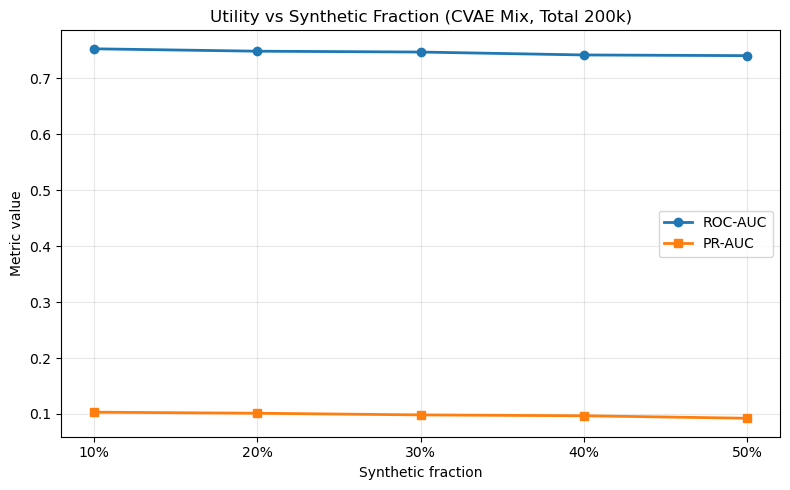


[8.7] Best ROC-AUC = 0.7524 at syn_frac = 0.10


In [44]:
# === 8.7 Visualization: Utility vs Synthetic Fraction (CVAE Mix, Total 200k) ===

import pandas as pd
import matplotlib.pyplot as plt

# 1) Load the sensitivity grid results from 8.6
grid_path = "utility_cvae_mix_grid_200k.csv"
df_cvae_grid = pd.read_csv(grid_path)

print("[8.7] Loaded CVAE mix grid results:")
print(df_cvae_grid)

# 2) Extract x (synthetic fraction) and y (metrics)
x = df_cvae_grid["syn_frac"].values
y_auc = df_cvae_grid["ROC-AUC"].values
y_pr  = df_cvae_grid["PR-AUC"].values

# 3) Plot ROC-AUC and PR-AUC as functions of synthetic fraction
plt.figure(figsize=(8, 5))

plt.plot(x, y_auc, marker="o", linewidth=2, label="ROC-AUC")
plt.plot(x, y_pr,  marker="s", linewidth=2, label="PR-AUC")

plt.title("Utility vs Synthetic Fraction (CVAE Mix, Total 200k)")
plt.xlabel("Synthetic fraction")
plt.ylabel("Metric value")

plt.grid(alpha=0.3)
plt.xticks(x, [f"{int(frac * 100)}%" for frac in x])
plt.legend()

plt.tight_layout()
plt.show()

# 4) Optional: print best setting by ROC-AUC
best_idx = y_auc.argmax()
print(f"\n[8.7] Best ROC-AUC = {y_auc[best_idx]:.4f} at syn_frac = {x[best_idx]:.2f}")

### 8.8 Fidelity Evaluation: Correlation Structure for CVAE Synthetic Data

In this section, we evaluate how well the **CVAE synthetic table** preserves
the dependency structure among the Safe Top-27 features.

Setup:

- Take a random sample of **200,000 real rows** from `df_clean`.
- Take the **200,000 CVAE synthetic rows** from  
  `synthetic/cvae_safe_top27_200k.parquet`.
- Drop the label and keep only the 27 Safe Top-27 features.
- Compute the **27×27 Pearson correlation matrix** for:
  - real sample (`corr_real`)
  - synthetic sample (`corr_syn`)
- Compute the element-wise absolute difference  
  `abs_diff = |corr_real - corr_syn|`.

We report:

- The **mean absolute correlation difference** as a scalar summary.
- The **top 10 most similar** feature pairs (smallest difference).
- The **top 10 most different** feature pairs (largest difference).
- A **heatmap** of the absolute correlation difference matrix.
- A **scatter plot** of `corr_real` vs `corr_syn` for all off-diagonal pairs.

If the CVAE preserves high-level structure, points in the scatter plot should
cluster around the diagonal line `y = x`, and the heatmap should be mostly
dark (small differences). Large and systematic deviations indicate that the
synthetic data are not capturing the real feature–feature dependencies well.

[8.8] Loaded df_cvae_syn: (200000, 28)
[8.8] Sampled real subset: (200000, 28)

[8.8] Mean absolute corr difference (real vs CVAE syn): 0.5292

=== Top 10 most similar pairs (smallest diff) ===
                      feat_i                  feat_j  corr_real  corr_syn  \
272      f_entities_len_mean              f_hour_cos  -0.050606 -0.048864   
161           f_refresh_mean          u_refreshTimes   0.996044  0.998143   
348  ad_click_list_v002_uniq  ad_click_list_v002_len   1.000000  0.996255   
41                f_cat_uniq             device_size   0.014208  0.020774   
71             f_refresh_sum        app_second_class   0.021847  0.031525   
341            spread_app_id        app_second_class  -0.079460 -0.091669   
309              device_size        hispace_app_tags  -0.013060 -0.025427   
306              device_size                  adv_id  -0.004757 -0.030654   
157            f_dislike_sum        app_second_class   0.017390 -0.009908   
110                   f_rows        

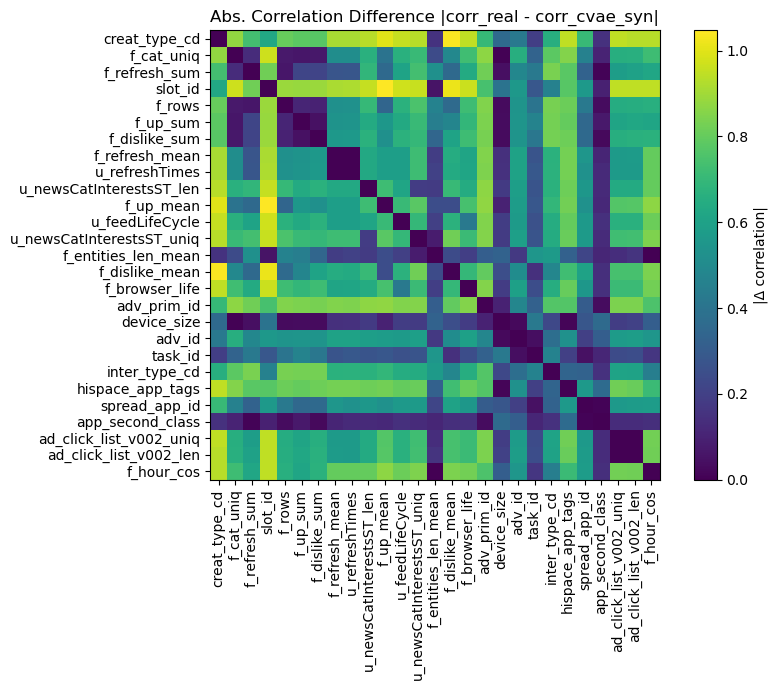

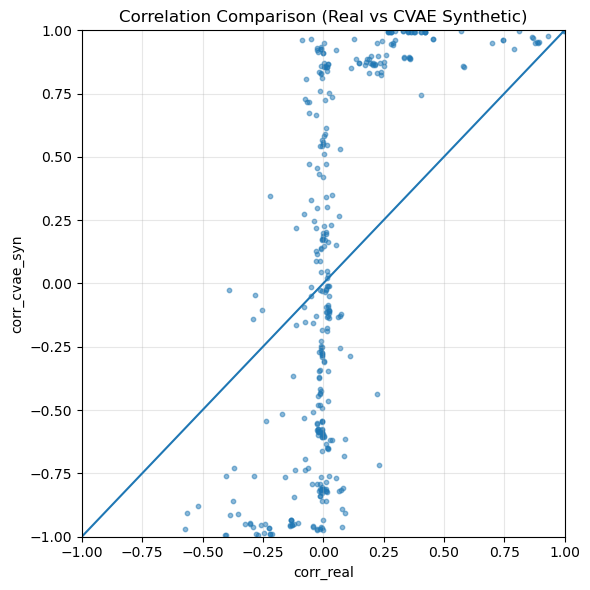

In [47]:
# === 8.8 Fidelity Evaluation: Correlation Structure for CVAE Synthetic Data ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load CVAE synthetic 200k
df_cvae_syn = pd.read_parquet("synthetic/cvae_safe_top27_200k.parquet")
print("[8.8] Loaded df_cvae_syn:", df_cvae_syn.shape)

# 2) Sample 200k real rows for a fair comparison
df_real_200k = df_clean.sample(n=200_000, random_state=42).reset_index(drop=True)
print("[8.8] Sampled real subset:", df_real_200k.shape)

# 3) Feature-only DataFrames
real_feats = df_real_200k[safe_top_feats].copy()
syn_feats  = df_cvae_syn[safe_top_feats].copy()

# 4) Correlation matrices
corr_real = real_feats.corr()
corr_syn  = syn_feats.corr()

# 5) Build pairwise difference table
pairs = []
cols = safe_top_feats

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        fi = cols[i]
        fj = cols[j]
        r_real = corr_real.loc[fi, fj]
        r_syn  = corr_syn.loc[fi, fj]
        abs_diff = abs(r_real - r_syn)
        pairs.append([fi, fj, r_real, r_syn, abs_diff])

pairs_df = pd.DataFrame(pairs, columns=[
    "feat_i", "feat_j", "corr_real", "corr_syn", "abs_diff"
])

pairs_sorted = pairs_df.sort_values("abs_diff")

# 6) Summary statistics
mean_abs_diff = pairs_df["abs_diff"].mean()
print("\n[8.8] Mean absolute corr difference (real vs CVAE syn):", round(mean_abs_diff, 4))

print("\n=== Top 10 most similar pairs (smallest diff) ===")
print(pairs_sorted.head(10))

print("\n=== Top 10 most different pairs (largest diff) ===")
print(pairs_sorted.tail(10))

# 7) Heatmap of |corr_real - corr_syn|
abs_corr_diff = (corr_real - corr_syn).abs().values

plt.figure(figsize=(9, 7))
plt.imshow(abs_corr_diff, interpolation="nearest")
plt.title("Abs. Correlation Difference |corr_real - corr_cvae_syn|")
plt.colorbar(label="|Δ correlation|")
plt.xticks(range(len(cols)), cols, rotation=90)
plt.yticks(range(len(cols)), cols)
plt.tight_layout()
plt.show()

# 8) Scatter plot: corr_real vs corr_syn for all off-diagonal pairs
plt.figure(figsize=(6, 6))
plt.scatter(pairs_df["corr_real"], pairs_df["corr_syn"], alpha=0.5, s=10)
plt.xlabel("corr_real")
plt.ylabel("corr_cvae_syn")
plt.title("Correlation Comparison (Real vs CVAE Synthetic)")

# Diagonal reference line y = x
lims = [-1, 1]
plt.plot(lims, lims)
plt.xlim(lims)
plt.ylim(lims)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 8.9 Privacy Evaluation I: Distance-to-Closest-Record (CVAE)

We first use a **distance-to-closest-record** heuristic to check whether
CVAE synthetic records are too close to any real record (which would
indicate potential memorization).

Steps:

1. Standardize all 27 Safe Top-27 features using the **mean and std from
   the real training pool** (`df_clean`).
2. Take:
   - 5,000 sampled **real** records (from the standardized real pool);  
   - 5,000 sampled **CVAE synthetic** records.
3. For each sampled point, compute the **Euclidean distance to its nearest
   neighbor among a large real reference pool** (e.g., 100k standardized
   real records).
4. Compare the distributions of
   - `real_to_real_min_dist` (real sample → real reference)
   - `syn_to_real_min_dist`  (synthetic sample → real reference)

We visualize both distributions using overlaid histograms and report
their mean values.

If **synthetic-to-real distances** are clearly larger than
**real-to-real distances**, this indicates that CVAE does *not* simply
replicate real records, and the risk of direct record-copying is lower.

[8.9] Standardized real feature pool: (7675517, 27)
[8.9] Reference real pool shape: (100000, 27)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[8.9] Probe real shape: (5000, 27)
[8.9] Probe syn  shape: (5000, 27)

[8.9] real→real mean min distance: 1.6791445
[8.9] syn →real mean min distance : 1.8987715


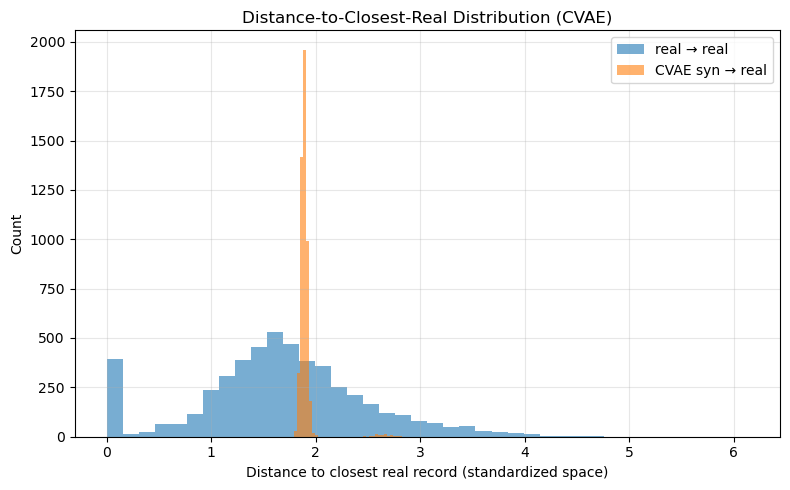

In [50]:
# === 8.9 Privacy I: Distance-to-Closest-Record (CVAE) ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

# 1) Build standardized real feature pool
real_features_full = df_clean[safe_top_feats].copy()

scaler_priv = StandardScaler()
real_features_std = scaler_priv.fit_transform(real_features_full)

print("[8.9] Standardized real feature pool:", real_features_std.shape)

# 2) Define a smaller real reference pool for distance computation
N_REF = 100_000
np.random.seed(42)

ref_idx = np.random.choice(real_features_std.shape[0], size=N_REF, replace=False)
ref_real_std = real_features_std[ref_idx]

print("[8.9] Reference real pool shape:", ref_real_std.shape)

# 3) Sample real and synthetic points to probe privacy
N_PROBE = 5_000

probe_real_idx = np.random.choice(real_features_std.shape[0], size=N_PROBE, replace=False)
probe_real_std = real_features_std[probe_real_idx]

# Load CVAE synthetic features and standardize with *real* scaler
df_cvae_syn_200k = pd.read_parquet("synthetic/cvae_safe_top27_200k.parquet")
syn_features_std = scaler_priv.transform(df_cvae_syn_200k[safe_top_feats].values)

probe_syn_idx = np.random.choice(syn_features_std.shape[0], size=N_PROBE, replace=False)
probe_syn_std = syn_features_std[probe_syn_idx]

print("[8.9] Probe real shape:", probe_real_std.shape)
print("[8.9] Probe syn  shape:", probe_syn_std.shape)

# 4) Compute distance-to-closest-real for each probe point
def min_dist_to_reference(probe, ref, batch_size=500):
    """
    For each row in probe, compute its distance to the nearest neighbor in ref.
    Computed in batches for memory efficiency.
    """
    n = probe.shape[0]
    min_dists = np.empty(n, dtype=np.float32)
    start = 0
    while start < n:
        end = min(start + batch_size, n)
        dists = pairwise_distances(probe[start:end], ref, metric="euclidean")
        min_dists[start:end] = dists.min(axis=1)
        start = end
    return min_dists

real_to_real_min = min_dist_to_reference(probe_real_std, ref_real_std, batch_size=500)
syn_to_real_min  = min_dist_to_reference(probe_syn_std,  ref_real_std, batch_size=500)

print("\n[8.9] real→real mean min distance:", real_to_real_min.mean())
print("[8.9] syn →real mean min distance :", syn_to_real_min.mean())

# 5) Plot histograms of distances
plt.figure(figsize=(8, 5))

bins = 40
plt.hist(real_to_real_min, bins=bins, alpha=0.6, label="real → real")
plt.hist(syn_to_real_min,  bins=bins, alpha=0.6, label="CVAE syn → real")

plt.xlabel("Distance to closest real record (standardized space)")
plt.ylabel("Count")
plt.title("Distance-to-Closest-Real Distribution (CVAE)")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()